## Instructions

Before you submit this project, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Please see the module book for full instructions on completing the project and submitting properly.

Make sure you *only* fill in places that say `your code goes here` or "YOUR ANSWER HERE". Replace the contents of those cells only, changing other cells may prevent grading. It is recommended to work in a copy and enter final answers in the submission version at the end.

When using matplotlib please make sure to use the inline option (not notebook) to allow grading: 
`%matplotlib inline`

Be aware, marks are available for following the usual good practice guidlines when creating Python code; e.g. good use of functions, efficient coding conventions, code comments etc. 

---

# MT4112 Project 1: Spectral differentiation

In this project we will consider the numerical differentiation of the following function

$$
f(x) = \cos(4\pi x)\cos(\pi x)
$$

## Q1

Define $f(x)$ and $f'(x),$ as Python functions `f(x)` and `df(x)`. Your functions should be able to operate on `numpy` arrays have one parameter and return one Python variable. **[2]**

In [1]:
# your code goes here

# Import relevant packages:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define f(x) as stated above:
def f(x):
    return np.cos(4*np.pi*x)*np.cos(np.pi*x)

# Differentiate f(x) analylitcally using chain rule:
def df(x):
    return (-4)*np.pi*np.sin(4*np.pi*x)*np.cos(np.pi*x) - np.pi*np.cos(4*np.pi*x)*np.sin(np.pi*x)

In [2]:
# Don't edit this cell

if not "f" in globals():
    raise NotImplementedError("f has not been defined in Question 1")
if not "df" in globals():
    raise NotImplementedError("df has not been defined in Question 1")


## Q2

Consider the interval $x\in[-1,1].$

Define four functions which have as parameters the number of grid points `N` and function handle `f`, and returns two arrays 
* an array of appropriate $x$ points for the method and,
* a numerical estimate of  $f'(x)$ on those points.
        
The functions/methods should be 

* `df_finite(N,f)` using second-order centered finite difference, using a differentiation matrix, on an evenly spaced **periodic** grid where $x(1)=x(-1)$.
* `df_Fourier(N,f)` using the Fourier spectral method, also on an evenly spaced periodic grid where $x(1)=x(-1)$.
* `df_Cheb1(N,f)` using the Chebyshev differentiation matrix, on the Chebyshev extremum points (code to construct the matrix can be taken from the notes).
* `df_Cheb2(N,f)` using the full Chebyshev series evaluated using the discrete cosine transform as shown in lectures, and differentiating using the `numpy` function [`cheb.chebder`](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebder.html), on the Chebyshev roots.


**[10]** (2 marks for each function and 2 marks for good practice)

In [3]:
# your code goes here

# Centred Difference Function
def df_finite(N, f):
    # Define interval:
    a = -1
    b = 1
    
    # Create a evenly spaced grid of N points, excluding 1 as isnt required in periodic case
    h = 2/N                            # Result from lectures when do not wwant to include final point on [-1,1]
    xvals = np.linspace(a,b-h,N)  
    
    # Create the empty differentiation matrix
    D = np.zeros((N, N))
    
    # Use numpy's fill_diagonal function on a sliced D such that Upper and Lower Diagonal entries are filled
    np.fill_diagonal(D[1:,:],-1)
    np.fill_diagonal(D[:,1:],1)
    
    # Apply the condition of periodicity 
    D[0, -1] = -1
    D[-1, 0] = 1
    
    # We must account for the seperation of grid points so divide all entries of D by 2h 
    D = D/(2*h)
    
    fvals = f(xvals)
    
    df_fin = (D@fvals)
    
    return xvals, df_fin


# Fast Fourier Transform Function
def df_Fourier(N, f):
    # Define interval and obtain step size:
    a = -1
    b = 1
    
    # Obtain x and f(x) values:
    xvals = np.linspace(a,b-(2/N),N)      # Convention to take the f(-1) value and not f(1) for periodic function, note h=2/N
    fvals = f(xvals)

    # Preform the real valued Fast Fourier Transformation and normalise it 
    fhat = np.fft.rfft(fvals)/N
   
    # For a DFT a period of 2pi is required so a transformation must be preformed on the given interval
    k = np.arange(0, N//2+1)*np.pi
    
    # d/dx for Fourier is simply ik* due to it being an exponential function
    dfhat = 1j * k* fhat
    
    # Using real valued inverse Fourier Transform to get values for df/dx
    df_Foure = np.fft.irfft(dfhat)*N
    
    return xvals, df_Foure

# Chebyshev Differentation Matrix Function
def df_Cheb1(N, f):
    
    # Use given function that outputs differencaiation matix, D, and Chebyshev Grid:
    def chebD(N):
        if N == 0:
            D = 0.; x = 1.       # If N=0, differentiation matrix is empty and polynomial is zeroth-order (ie 1)
        else:
            n = np.arange(0, N)  # Only require N estimates for df so change given code to match this
            x = np.cos(np.pi * n / (N - 1)).reshape(N, 1)
            c = (np.hstack(([2.], np.ones(N - 2), [2.])) * ((-1) ** n)).reshape(N, 1)
            X = np.tile(x, (1, N))
            dX = X - X.T
            D = np.dot(c, 1. / c.T) / (dX + np.eye(N))
            D -= np.diag(np.sum(D.T, axis=0))
        return D, x.reshape(N)

    D, x = chebD(N)              # Use function to obtain differentiation matrix and Chebyshev grid points       
    
    fvals = f(x)                 # Apply Chebyshev Grid to our given function
    
    df_C1 = D @ fvals            # Find derivative of our function f by multiplying Diff. Matrix and fvals
    
    return x, df_C1


# import relevant packages for Cosine Transform and Chebyshev Opperations
from scipy.fftpack import fft, dct
from numpy.polynomial import chebyshev as cheb

# Chebyshev Series function
def df_Cheb2(N, f):
    
    # Make Chebyshev points
    n = np.arange(0, N)  
    xvals = np.cos(np.pi * n / (N - 1))
    
    fvals = f(xvals)                         # Evaluate our function at Chebyshev points
    
    # Apply a discrete cosine tranform to obtain a cosine series
    a = dct(fvals, type=1, n=N)/(2*N - 2)        
    a[1:-1] *=2                              # Apply standard conventions
    
    # Use chebder to obtain the derivative of the Chebyshev series
    da = cheb.chebder(a[0:])
    
    # Evaluate the Chebyshev Series
    df_C2 = cheb.chebval(xvals, da)
    
    return xvals, df_C2

In [4]:
# Don't edit this cell

if not "df_finite" in globals():
    raise NotImplementedError("df_finite has not been defined in Question 2")
if not "df_Fourier" in globals():
    raise NotImplementedError("df_Fourier has not been defined in Question 2")
if not "df_Cheb1" in globals():
    raise NotImplementedError("df_Cheb1 has not been defined in Question 2")
if not "df_Cheb2" in globals():
    raise NotImplementedError("df_Cheb2 has not been defined in Question 2")



## Q3
    
For $N\in\{2^3,2^4,..,2^{10}\}$ obtain the $L_\infty$ error between the numerical approximation and the exact $f'(x),$ plotting the four numerical approximations on the same log-log axes, taking care to label your plot. **[3]**

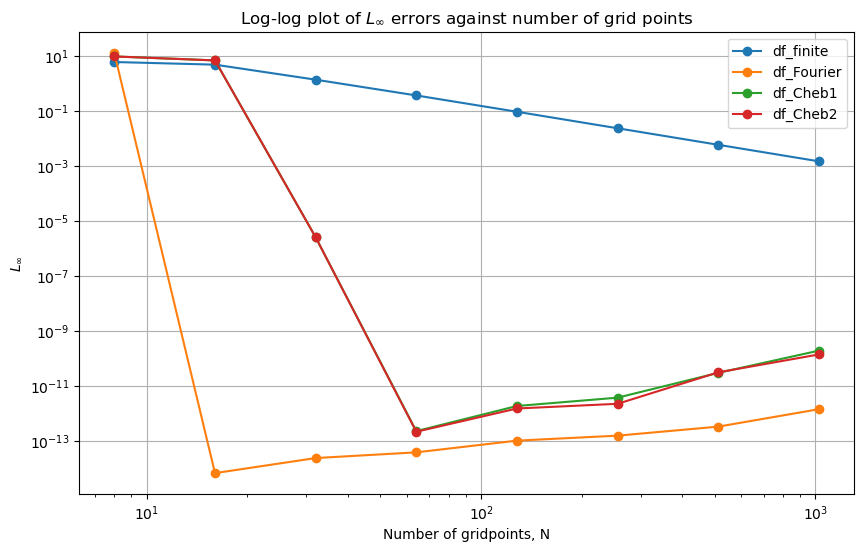

In [5]:
# your code goes here

# Simple Loop to create an array of different values for N
Nvals = np.zeros(8, dtype=int)
for i in range(3,11,1):
    Nvals[i-3] = int(2**i)
    
# Create store for the errors 
Finite_E = np.zeros(8)
Fourier_E = np.zeros(8)
Cheb1_E = np.zeros(8)
Cheb2_E = np.zeros(8)

# Loop through different N values and calculate L∞ errors, where L∞ is the infinity norm 
i = 0
for N in Nvals:
    # Obtain estimates and associated x values for each method
    x_finite, df_fin = df_finite(N,f)
    x_Fourier, df_Four = df_Fourier(N,f)
    x_C1, df_C1 = df_Cheb1(N,f)
    x_C2, df_C2 = df_Cheb2(N,f)
    
    # Evaluate L∞ errors for each method using standard infinity norm formula
    Finite_E[i] = np.max(np.abs(df_fin - df(x_finite)))
    Fourier_E[i] = np.max(np.abs(df_Four - df(x_Fourier)))
    Cheb1_E[i] = np.max(np.abs(df_C1 - df(x_C1)))
    Cheb2_E[i] = np.max(np.abs(df_C2 - df(x_C2)))
    
    i = i + 1

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Log-log plot of $L_\infty$ errors against number of grid points')  
ax1.set_xlabel('Number of gridpoints, N')
ax1.set_ylabel('$L_\infty$')
ax1.loglog(Nvals, Finite_E,'-o', label='df_finite')
ax1.loglog(Nvals, Fourier_E,'-o', label='df_Fourier')
ax1.loglog(Nvals, Cheb1_E,'-o', label='df_Cheb1')
ax1.loglog(Nvals, Cheb2_E,'-o', label='df_Cheb2')
ax1.grid(True)
ax1.legend();

## Q4

Time your functions with an appropriate method, taking care to account for function overhead. Plot your timing data to help answer the mutliple choice questions below. **[3]**

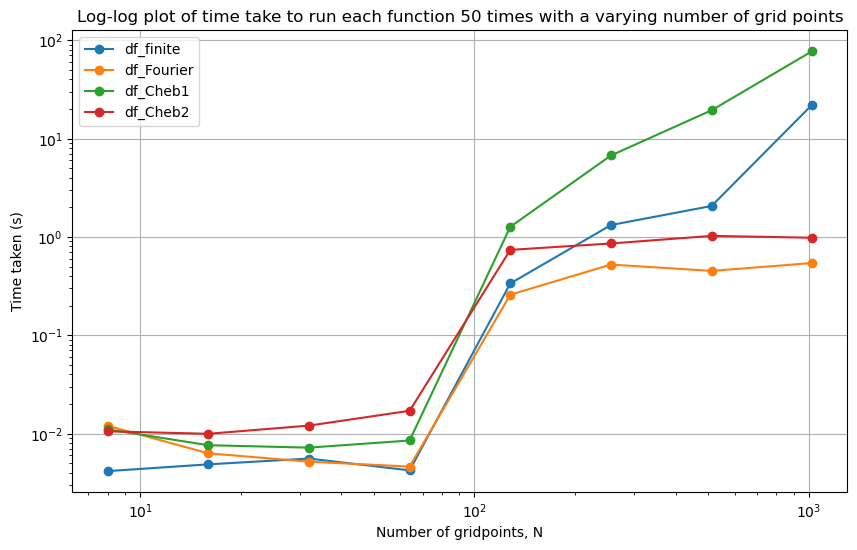

In [13]:
# your code goes here
# Import a simple siming function
from time import process_time

# Simple Loop to create an array of different values for N to test over
Nvals = np.zeros(8, dtype=int)
for i in range(3,11,1):
    Nvals[i-3] = int(2**i)
    
# Create empty lists to store the execution times
finite_times = []
Fourier_times =[]
Cheb1_times = []
Cheb2_times =[]

for N in Nvals:
    # Time the df_finite function 50 times for each N (to account for some function call overhead)
    start = process_time()
    for i in range(50):
        df_finite(N,f)
    stop = process_time() 
    elasped = stop-start
    finite_times.append(elasped)
    
    # Time the df_Fourier function 50 times for each N
    start = process_time()
    for i in range(50):
        df_Fourier(N,f)
    stop = process_time() 
    elasped = stop-start
    Fourier_times.append(elasped)
    
    # Time the df_Cheb1 function 50 times for each N
    start = process_time()
    for i in range(50):
        df_Cheb1(N,f)
    stop = process_time() 
    elasped = stop-start
    Cheb1_times.append(elasped)
    
    # Time the df_Cheb2 function 50 times for each N
    start = process_time()
    for i in range(50):
        df_Cheb2(N,f)
    stop = process_time() 
    elasped = stop-start
    Cheb2_times.append(elasped)
    
# Plot of timing data
fig, ax2 = plt.subplots(figsize=(10,6))
ax2.set_title('Log-log plot of time take to run each function 50 times with a varying number of grid points')  
ax2.set_xlabel('Number of gridpoints, N')
ax2.set_ylabel('Time taken (s)')
ax2.loglog(Nvals, finite_times,'-o', label='df_finite')
ax2.loglog(Nvals, Fourier_times,'-o', label='df_Fourier')
ax2.loglog(Nvals, Cheb1_times,'-o', label='df_Cheb1')
ax2.loglog(Nvals, Cheb2_times,'-o', label='df_Cheb2')
ax2.grid(True)
ax2.legend();



Determine the answers to the following questions, creating variable names `A1`, `A2`, `A3`, `A4` and `A5` setting their value to be the single character string `a`, `b`, or `c` corresponding to your answer:

### 4.1

With a large number of points, the fastest numerical differentiation method is usually **[1/2]**

**a** Fourier

**b** Finite difference

**c** Chebyshev Polynomial

**d** Chebyshev Series

### 4.2
Given a certain amount of CPU time the least accurate numerical differentiation method is usually **[1/2]**

**a** Fourier

**b** Finite difference

**c** Chebyshev Polynomial

**d** Chebyshev Series

### 4.3
Overall, in terms of efficiency, the best approach to numerically differentiate this function is **[1/2]**

**a** Fourier

**b** Finite difference

**c** Chebyshev Polynomial

**d** Chebyshev Series

### 4.4
It is appropriate to use large numbers of points for the Fourier method for this function. **[1/2]**

**a** True

**b** False

In [7]:
# your code goes here
# Answers to multiple choice questions
A1 = 'a'
A2 = 'b'
A3 = 'a'
A4 = 'b'

In [8]:
# Don't edit this cell

if not "A1" in globals():
    raise NotImplementedError("A1 has not been defined in Question 4")
if not "A2" in globals():
    raise NotImplementedError("A2 has not been defined in Question 4")
if not "A3" in globals():
    raise NotImplementedError("A3 has not been defined in Question 4")
if not "A4" in globals():
    raise NotImplementedError("A4 has not been defined in Question 4")



## Q5

If we were to change the test function to 

$$
g(x) = \mathrm{sech}^2(x)
$$

which method (or methods) would be expected to perform best and why? Put your answer as a *short* free text response in the markdown cell below, you should not include any code or results. **[2]**

YOUR ANSWER HERE

Either Chebyshev Method would tackle this function best from an error stand point. The function $\mathrm{sech}^2(x)$ is **not** a periodic function, thus neither is it's derivative. Hence the Fourier function will preform worse. Our finite difference function relys on the periodicity of the given f(x). If the differentation matrix was modified to not include periodicity the error only scales with N, but is computationally taxing. I reccomend df_cheb2 as it is more effient with an extremely similar accuracy compared to df_cheb2. 

## Q6

A fourth-order finite difference scheme can be defined as

$$
f'(x_j) \approx \frac{f_{j-2}-8f_{j-1} + 8f_{j+1} - f_{j+2}}{12h}
$$

Implement this scheme via a differentiation matrix in the same format as the function `df_finite(N,f)` now called `df_finite4(N,f)`.

Take care with the periodicity of the grid. Create a Python variable `err_FD4` for the $L_\infty$ error with $N=128$. **[3]**

In [15]:
# your code goes here

# Fourth-order Centred Difference function 
def df_finite4(N,f):
    # Same set-up as df_finite can be used, only differentation matrix varies
    # Define interval:
    a = -1
    b = 1
    
    # Create a evenly spaced grid of N points, excluding 1 as isnt required in periodic case
    h = 2/N                            # Result from lectures
    xvals = np.linspace(a,b-h,N)     
                 
    
    # Create empty differentation matrix
    D = np.zeros((N,N))
    
    # Use np.fill_diagonal to fill in off diagonals values
    np.fill_diagonal(D[2:,:], 1)
    np.fill_diagonal(D[1:,:], -8)
    np.fill_diagonal(D[:,1:], 8)
    np.fill_diagonal(D[:,2:], -1)
    
    # Manually add missing values that account for periodicity
    D[0,-2] = 1
    D[1,-1] = 1
    
    D[0,-1] = -8
    
    D[-1,0] = 8
    
    D[-1,1] = -1
    D[-2,0] = -1
    
    # We must divide each entry by 12h to stay consistant with formula
    D = D/(12*h)
    
    fvals = f(xvals)
    
    df_fin4 = (D@fvals)
    
    return xvals, df_fin4

N = 128
xvals, df_fin4vals = df_finite4(N,f)
err_FD4 = np.max(np.abs(df(xvals) - df_fin4vals))
err_FD4

0.0009962116568615897

In [13]:
# Don't edit this cell

if not "df_finite4" in globals():
    raise NotImplementedError("df_finite4 has not been defined in Question 6")
if not "err_FD4" in globals():
    raise NotImplementedError("err_FD4 has not been defined in Question 6")

